In [33]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import layers, models

# for creating test labels
import csv
import os
import shutil


In [38]:
# Visualization libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


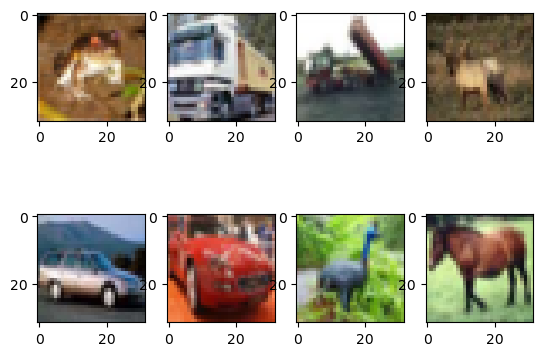

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [10]:
# Convolution model
model1 = models.Sequential()
input_shape = (32, 32, 3)  # Input shape of the image
num_classes = 10  # Number of output classes (0-9 inclusive)

### ATTEMPT 1 : ACC 10%

# # layers
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# # Flatten the output for Dense layers
# model.add(layers.Flatten())

# # dense layers
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with softmax activation for classification

### ATTEMPT 2 

# Convolutional layers
model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model1.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for Dense layers
model1.add(layers.Flatten())

# Dense layers
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(num_classes, activation='softmax'))  


# ### ATTEMPT 3 ACC 38.6%

# model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))

# model1.add(layers.Conv2D(32, (3, 3), padding = 'same'))
# model1.add(layers.Activation('relu'))

# model1.add(layers.MaxPooling2D(pool_size= (2,2)))
# model1.add(layers.Dropout(0.25))

# model1.add(layers.Conv2D(64, (3, 3), padding = 'same'))
# model1.add(layers.Activation('relu'))

# model1.add(layers.Conv2D(64, (3, 3)))
# model1.add(layers.Activation('relu'))

# model1.add(layers.MaxPooling2D(pool_size= (2, 2)))
# model1.add(layers.Dropout(0.25))

# #Dense layers
# model1.add(layers.Flatten())
# model1.add(layers.Dense(512))
# model1.add(layers.Activation('relu'))
# model1.add(layers.Dropout(0.5))
# model1.add(layers.Dense(num_classes))
# model1.add(layers.Activation('softmax'))

# Compile the model
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # so no need for one hot encoding
              metrics=['accuracy'])

# Print model summary
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [11]:
x_train = imgs[10000:, :, :, :]  # all images after first 10000
x_test = imgs[:10000, :, : , :]  # first 10000 clean images

y_train = noisy_labels[10000:] # train on all noisy labels after first 10000
y_test = clean_labels #clean labels for first 10000 images

In [12]:
# Train the model
history = model1.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model1.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10


2024-03-19 16:33:26.795965: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1250/1250 [==============================] - 48s 38ms/step - loss: 2.3163 - accuracy: 0.1241 - val_loss: 2.1285 - val_accuracy: 0.2429
Epoch 2/10
1250/1250 [==============================] - 46s 37ms/step - loss: 2.2720 - accuracy: 0.1516 - val_loss: 2.1376 - val_accuracy: 0.3301
Epoch 3/10
1250/1250 [==============================] - 47s 37ms/step - loss: 2.2581 - accuracy: 0.1726 - val_loss: 2.0758 - val_accuracy: 0.3429
Epoch 4/10
1250/1250 [==============================] - 47s 38ms/step - loss: 2.2467 - accuracy: 0.1852 - val_loss: 1.9947 - val_accuracy: 0.4042
Epoch 5/10
1250/1250 [==============================] - 49s 39ms/step - loss: 2.2411 - accuracy: 0.1904 - val_loss: 1.9990 - val_accuracy: 0.3876
Epoch 6/10
1250/1250 [==============================] - 49s 40ms/step - loss: 2.2347 - accuracy: 0.1983 - val_loss: 1.9870 - val_accuracy: 0.3822
Epoch 7/10
1250/1250 [==============================] - 51s 41ms/step - loss: 2.2272 - accuracy: 0.2049 - val_loss: 1.9698 - val_accura

In [45]:
# Treats noisy labels as clean labels and does not differentiate between the two
# Input : (32, 32, 3) (32x32 pixels, 3 RGB channel) image
# Output : Numerical classification label [0-9] 
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    img_data = np.zeros((1, 32, 32, 3))
    img_data[0] = image
    probs = model1.predict(img_data[:1, :, :, :],verbose = 0) # verbose to stop printing the time/step line
    return np.argmax(probs)

In [26]:
# save cnn model
model1.save('model1_V1.h5')  # Save in HDF5 format

[[0.08505396 0.16205873 0.07207845 0.07869598 0.05690672 0.08659212
  0.06432969 0.05944193 0.11188725 0.2229551 ]]


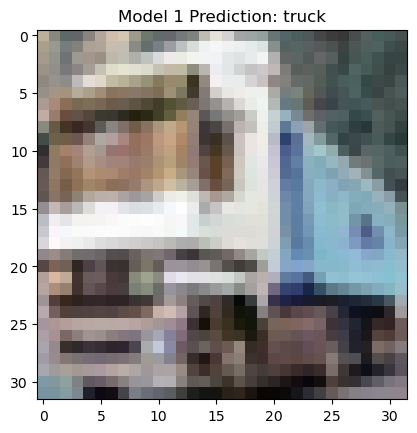

In [43]:
# Example 
folder_path =  "/Users/swzhao/Desktop/Columbia/Applied Data Science/Project 2 - Weakly Supervised learning/"
img = cv2.imread(folder_path+'data/images/00002.png')

plt.imshow(img)
plt.title("Model 1 Prediction: " + str(classes[int(model_I(img))]))
plt.show()

### Some commentary on Model I

This is a convolutional neural network which is a more sophisticated framework than the baseline logistic regression model given to us.

The model achieved a final test accuracy of 0.4414 after running for 10 epochs on the noisy labeled images. This accuracy is much higher than random guess (which would have an expected accuracy of 0.10 assuming equally uniform distribution of all image categories) and decently higher than the baseline regression model's accurary of 0.24. 

This model can be further improved through several following means:
 - Data augmentation of the images we are training and testing on (this gives the model more information to work with)
 - More sophisticated weights and layers
 - More training data and more training time (we see that val_accuracy fluctuates around ~0.4 while training_accuracy is incrementally increasing. We would like to avoid overfitting while converging around the optimal weights. Perhaps a narrower and finer step size than the default Optimizer Adam's 0.001 would be better).
 
However, for demonstration purposes, this model is sufficient in showcasing superior abilities compared to the logistic model
 
Of course, the data and corresponding label quality is also very important for the model. Having clean labels and not erroneous labels would be very beneficial. This is what we are going to explore in part II.


### Some Visualizations for Model I

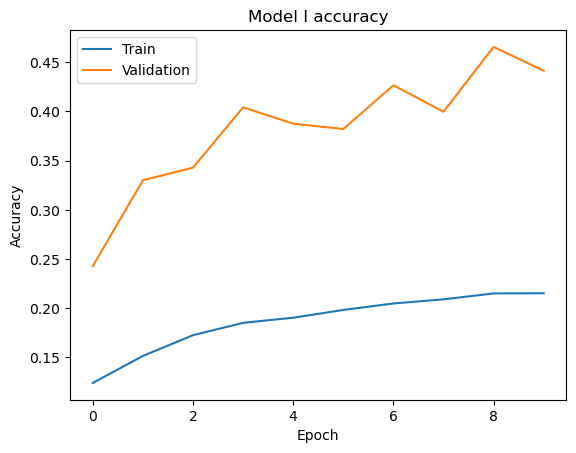

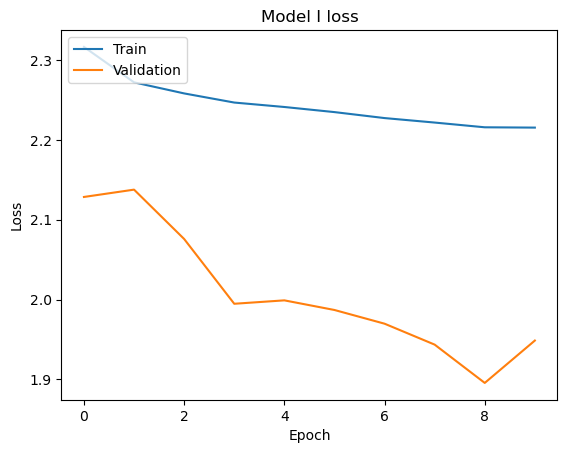

In [32]:
## Accuracy and Loss

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model I accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model I loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
# Get set of predictions
y_true = clean_labels
y_pred = [model_I(img) for img in imgs[:10000]]

In [48]:
# Predicted probabilities
y_pred_prob = []

for img in imgs[:10000]:
    img_data = np.zeros((1, 32, 32, 3))
    img_data[0] = img
    probs = model1.predict(img_data[:1, :, :, :],verbose = 0) # verbose to stop printing the time/step line
    
    y_pred_prob.append(probs)

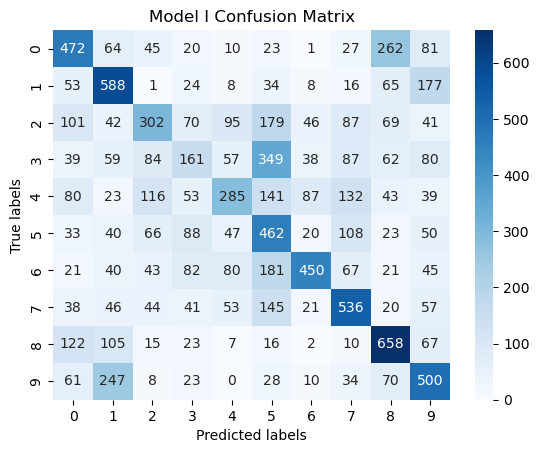

In [41]:
## Confusion Matrix

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Model I Confusion Matrix')
plt.show()

In [51]:
# ## ROC curve

# fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Model I Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

### 2.3. Model II

In [77]:
dataset = torch.utils.data.TensorDataset(
    torch.Tensor(imgs.transpose([0, 3, 1, 2])[2000:]).to(device),
    torch.LongTensor(noisy_labels[2000:]).to(device))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)
clean_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(imgs[2000:10000].transpose([0, 3, 1, 2])).to(device),
    torch.LongTensor(clean_labels[2000:]).to(device),
    torch.LongTensor(noisy_labels[2000:10000]).to(device))
clean_dataloader = torch.utils.data.DataLoader(clean_dataset, batch_size=64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(imgs.transpose([0, 3, 1, 2])[:2000]).to(device),
    torch.LongTensor(noisy_labels[:2000]).to(device),
    torch.LongTensor(clean_labels[:2000]).to(device))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

resnet = ResNet([3, 4, 6, 3]).to(device)

class LabelCorrection(nn.Module):
    def __init__(self, feature_size, n_class = 10):
        super().__init__()
        self.eye = torch.eye(n_class).to(device)
        input_size = feature_size + n_class * 2
        self.network = nn.Sequential(
            nn.Linear(input_size, input_size // 2),
            nn.ReLU(),
            nn.Linear(input_size // 2, n_class),
        )

    def forward(self, feature, logit, noisy_label):
        noisy_label = self.eye[noisy_label]
        x = torch.concat([feature, logit, noisy_label], dim=-1)
        return self.network(x)

label_corrector = LabelCorrection(2048).to(device)
    
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters())
label_corrector_optimizer = torch.optim.Adam(label_corrector.parameters())

best_acc = 0
for epoch in range(100):
    total_loss = 0
    total_correct = 0
    total_clean_correct = 0
    clean_dataloader_iter = iter(clean_dataloader)
    for x, y in tqdm(dataloader):
        try:
            clean_x, clean_y, noisy_y = next(clean_dataloader_iter)
        except StopIteration:
            clean_dataloader_iter = iter(clean_dataloader)
            clean_x, clean_y, noisy_y = next(clean_dataloader_iter)

        # train label corrector
        logit, feature = resnet.forward_with_feature(clean_x)
        logit = label_corrector(feature, logit.detach(), noisy_y)
        clean_loss = loss_func(logit, clean_y)
        
        total_clean_correct += (logit.argmax(dim=-1) == clean_y).sum()
        label_corrector_optimizer.zero_grad()
        optimizer.zero_grad()
        clean_loss.backward()
        label_corrector_optimizer.step()

        # train resnet
        logit, feature = resnet.forward_with_feature(x)
        cleaned_y = label_corrector(feature, logit.detach(), y).detach().argmax(dim=-1)
        loss = loss_func(logit, cleaned_y)

        total_correct += (logit.argmax(dim=-1) == y).sum()
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    val_total_loss = 0
    val_total_correct = 0
    val_clean_total_correct = 0
    for x, noisy_y, y in tqdm(val_dataloader):
        logit, feature = resnet.forward_with_feature(x)
        clean_logit = label_corrector(feature, logit, noisy_y)
        loss = loss_func(logit, y)
        val_clean_total_correct += (clean_logit.argmax(dim=-1) == y).sum()
        val_total_correct += (logit.argmax(dim=-1) == y).sum()
        val_total_loss += loss.item()
    print(f'Epoch {epoch}, loss = {total_loss / len(dataset)}, clean accuracy = {total_clean_correct / len(dataset)}, val clean accuracy = {val_clean_total_correct / len(val_dataset)}, val accuracy = {val_total_correct / len(val_dataset)}')

    val_acc = val_total_correct / len(val_dataset)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(resnet.state_dict(), 'model2.ckpt')
        print('save model')

100%|██████████| 32/32 [00:00<00:00, 182.33it/s]


Epoch 0, loss = 0.03350886029315492, clean accuracy = 0.3481041491031647, test clean accuracy = 0.46000000834465027, val accuracy = 0.3330000042915344
save model


100%|██████████| 32/32 [00:00<00:00, 173.12it/s]


Epoch 1, loss = 0.019323413581897816, clean accuracy = 0.5091041326522827, test clean accuracy = 0.5470000505447388, val accuracy = 0.4545000195503235
save model


100%|██████████| 32/32 [00:00<00:00, 183.35it/s]


Epoch 2, loss = 0.015993190329521893, clean accuracy = 0.5745833516120911, test clean accuracy = 0.5805000066757202, val accuracy = 0.48750001192092896
save model


100%|██████████| 32/32 [00:00<00:00, 192.64it/s]


Epoch 3, loss = 0.013512143656611443, clean accuracy = 0.6466875076293945, test clean accuracy = 0.5925000309944153, val accuracy = 0.5335000157356262
save model


100%|██████████| 32/32 [00:00<00:00, 189.43it/s]


Epoch 4, loss = 0.01142574041398863, clean accuracy = 0.7456250190734863, test clean accuracy = 0.6065000295639038, val accuracy = 0.5649999976158142
save model


100%|██████████| 32/32 [00:00<00:00, 187.50it/s]


Epoch 5, loss = 0.010005703448007504, clean accuracy = 0.8533124923706055, test clean accuracy = 0.5325000286102295, val accuracy = 0.4855000376701355


100%|██████████| 32/32 [00:00<00:00, 172.20it/s]


Epoch 6, loss = 0.009578539829080303, clean accuracy = 0.9086874723434448, test clean accuracy = 0.6055000424385071, val accuracy = 0.578000009059906
save model


100%|██████████| 32/32 [00:00<00:00, 201.84it/s]


Epoch 7, loss = 0.009122713283946116, clean accuracy = 0.9286041855812073, test clean accuracy = 0.6065000295639038, val accuracy = 0.5649999976158142


100%|██████████| 32/32 [00:00<00:00, 187.95it/s]


Epoch 8, loss = 0.008089295765540253, clean accuracy = 0.953166663646698, test clean accuracy = 0.6160000562667847, val accuracy = 0.5750000476837158


100%|██████████| 32/32 [00:00<00:00, 172.00it/s]


Epoch 9, loss = 0.006817618185499062, clean accuracy = 0.9756458401679993, test clean accuracy = 0.6295000314712524, val accuracy = 0.5745000243186951


100%|██████████| 32/32 [00:00<00:00, 156.36it/s]


Epoch 10, loss = 0.007071895593078807, clean accuracy = 0.9669791460037231, test clean accuracy = 0.6145000457763672, val accuracy = 0.5800000429153442
save model


100%|██████████| 32/32 [00:00<00:00, 194.47it/s]


Epoch 11, loss = 0.006194922227645293, clean accuracy = 0.9776250123977661, test clean accuracy = 0.6115000247955322, val accuracy = 0.5695000290870667


100%|██████████| 32/32 [00:00<00:00, 176.27it/s]


Epoch 12, loss = 0.0053414029455549706, clean accuracy = 0.9856249690055847, test clean accuracy = 0.6415000557899475, val accuracy = 0.5715000033378601


100%|██████████| 32/32 [00:00<00:00, 179.09it/s]


Epoch 13, loss = 0.005179798007147232, clean accuracy = 0.9852499961853027, test clean accuracy = 0.6170000433921814, val accuracy = 0.5875000357627869
save model


100%|██████████| 32/32 [00:00<00:00, 142.45it/s]


Epoch 14, loss = 0.004897008797372109, clean accuracy = 0.9867291450500488, test clean accuracy = 0.6335000395774841, val accuracy = 0.5695000290870667


100%|██████████| 32/32 [00:00<00:00, 173.75it/s]


Epoch 15, loss = 0.005183857321089211, clean accuracy = 0.9821249842643738, test clean accuracy = 0.627500057220459, val accuracy = 0.5665000081062317


100%|██████████| 32/32 [00:00<00:00, 186.68it/s]


Epoch 16, loss = 0.004389006572668829, clean accuracy = 0.9906458258628845, test clean accuracy = 0.6380000114440918, val accuracy = 0.5835000276565552


100%|██████████| 32/32 [00:00<00:00, 157.96it/s]


Epoch 17, loss = 0.0036760086602929125, clean accuracy = 0.9943749904632568, test clean accuracy = 0.6300000548362732, val accuracy = 0.5725000500679016


100%|██████████| 32/32 [00:00<00:00, 198.27it/s]


Epoch 18, loss = 0.0036684855734735416, clean accuracy = 0.9925416707992554, test clean accuracy = 0.6150000095367432, val accuracy = 0.5660000443458557


100%|██████████| 32/32 [00:00<00:00, 188.84it/s]


Epoch 19, loss = 0.0036288303567222706, clean accuracy = 0.9916666746139526, test clean accuracy = 0.6035000085830688, val accuracy = 0.5649999976158142


100%|██████████| 32/32 [00:00<00:00, 198.52it/s]


Epoch 20, loss = 0.0033967199655792987, clean accuracy = 0.9932708144187927, test clean accuracy = 0.609000027179718, val accuracy = 0.5635000467300415


100%|██████████| 32/32 [00:00<00:00, 177.91it/s]


Epoch 21, loss = 0.003218028879869962, clean accuracy = 0.9940833449363708, test clean accuracy = 0.612000048160553, val accuracy = 0.57750004529953


100%|██████████| 32/32 [00:00<00:00, 201.51it/s]


Epoch 22, loss = 0.003306860097887693, clean accuracy = 0.9916874766349792, test clean accuracy = 0.6145000457763672, val accuracy = 0.5720000267028809


100%|██████████| 32/32 [00:00<00:00, 211.56it/s]


Epoch 23, loss = 0.00331873059427744, clean accuracy = 0.9918749928474426, test clean accuracy = 0.6150000095367432, val accuracy = 0.5690000057220459


100%|██████████| 32/32 [00:00<00:00, 202.04it/s]


Epoch 24, loss = 0.00295389624107338, clean accuracy = 0.9950833320617676, test clean accuracy = 0.628000020980835, val accuracy = 0.5785000324249268


100%|██████████| 32/32 [00:00<00:00, 207.01it/s]


Epoch 25, loss = 0.0028683471669937715, clean accuracy = 0.9946249723434448, test clean accuracy = 0.612000048160553, val accuracy = 0.5710000395774841


100%|██████████| 32/32 [00:00<00:00, 197.64it/s]


Epoch 26, loss = 0.0035615477269893745, clean accuracy = 0.9894583225250244, test clean accuracy = 0.6060000061988831, val accuracy = 0.5550000071525574


100%|██████████| 32/32 [00:00<00:00, 195.35it/s]


Epoch 27, loss = 0.0037027132934114586, clean accuracy = 0.9867708086967468, test clean accuracy = 0.612500011920929, val accuracy = 0.5645000338554382


100%|██████████| 32/32 [00:00<00:00, 209.65it/s]


Epoch 28, loss = 0.0026553381606330127, clean accuracy = 0.9949166774749756, test clean accuracy = 0.6085000038146973, val accuracy = 0.5700000524520874


100%|██████████| 32/32 [00:00<00:00, 207.86it/s]


Epoch 29, loss = 0.00299338708982638, clean accuracy = 0.9923332929611206, test clean accuracy = 0.6060000061988831, val accuracy = 0.5730000138282776


100%|██████████| 32/32 [00:00<00:00, 212.00it/s]


Epoch 30, loss = 0.002202574205955898, clean accuracy = 0.9975624680519104, test clean accuracy = 0.612500011920929, val accuracy = 0.5545000433921814


100%|██████████| 32/32 [00:00<00:00, 196.45it/s]


Epoch 31, loss = 0.002363075774917282, clean accuracy = 0.9949374794960022, test clean accuracy = 0.6055000424385071, val accuracy = 0.5505000352859497


100%|██████████| 32/32 [00:00<00:00, 184.75it/s]


Epoch 32, loss = 0.00251731112608104, clean accuracy = 0.9947082996368408, test clean accuracy = 0.6210000514984131, val accuracy = 0.5715000033378601


100%|██████████| 32/32 [00:00<00:00, 215.10it/s]


Epoch 33, loss = 0.002037213559923354, clean accuracy = 0.996833324432373, test clean accuracy = 0.612000048160553, val accuracy = 0.5710000395774841


100%|██████████| 32/32 [00:00<00:00, 206.73it/s]


Epoch 34, loss = 0.0027253824908548266, clean accuracy = 0.9928749799728394, test clean accuracy = 0.6095000505447388, val accuracy = 0.565500020980835


100%|██████████| 32/32 [00:00<00:00, 205.15it/s]


Epoch 35, loss = 0.001918574187271588, clean accuracy = 0.9971458315849304, test clean accuracy = 0.609000027179718, val accuracy = 0.550000011920929


100%|██████████| 32/32 [00:00<00:00, 199.13it/s]


Epoch 36, loss = 0.002374930948797555, clean accuracy = 0.9942499995231628, test clean accuracy = 0.6025000214576721, val accuracy = 0.550000011920929


100%|██████████| 32/32 [00:00<00:00, 204.04it/s]


Epoch 37, loss = 0.0023149357889027064, clean accuracy = 0.9957083463668823, test clean accuracy = 0.6235000491142273, val accuracy = 0.5640000104904175


100%|██████████| 32/32 [00:00<00:00, 193.87it/s]


Epoch 38, loss = 0.0023492823950582533, clean accuracy = 0.9961666464805603, test clean accuracy = 0.6020000576972961, val accuracy = 0.5630000233650208


100%|██████████| 32/32 [00:00<00:00, 205.38it/s]


Epoch 39, loss = 0.0020171012544766805, clean accuracy = 0.9974583387374878, test clean accuracy = 0.6115000247955322, val accuracy = 0.5534999966621399


100%|██████████| 32/32 [00:00<00:00, 198.15it/s]


Epoch 40, loss = 0.0023384758229828247, clean accuracy = 0.9955624938011169, test clean accuracy = 0.5985000133514404, val accuracy = 0.5649999976158142


100%|██████████| 32/32 [00:00<00:00, 196.61it/s]


Epoch 41, loss = 0.002135888534457384, clean accuracy = 0.9955832958221436, test clean accuracy = 0.6020000576972961, val accuracy = 0.5455000400543213


100%|██████████| 32/32 [00:00<00:00, 207.35it/s]


Epoch 42, loss = 0.0019339937791676978, clean accuracy = 0.9963749647140503, test clean accuracy = 0.612000048160553, val accuracy = 0.5505000352859497


100%|██████████| 32/32 [00:00<00:00, 197.22it/s]


Epoch 43, loss = 0.0018790971397029351, clean accuracy = 0.9975833296775818, test clean accuracy = 0.6135000586509705, val accuracy = 0.5555000305175781


100%|██████████| 32/32 [00:00<00:00, 190.85it/s]


Epoch 44, loss = 0.001719500456877237, clean accuracy = 0.9972708225250244, test clean accuracy = 0.6170000433921814, val accuracy = 0.5485000014305115


100%|██████████| 32/32 [00:00<00:00, 196.22it/s]


Epoch 45, loss = 0.0019519163957556884, clean accuracy = 0.9962708353996277, test clean accuracy = 0.5905000567436218, val accuracy = 0.5595000386238098


100%|██████████| 32/32 [00:00<00:00, 188.18it/s]


Epoch 46, loss = 0.0018824913803024781, clean accuracy = 0.9972708225250244, test clean accuracy = 0.612000048160553, val accuracy = 0.5600000023841858


100%|██████████| 32/32 [00:00<00:00, 211.42it/s]


Epoch 47, loss = 0.0015074394506803704, clean accuracy = 0.9982500076293945, test clean accuracy = 0.6135000586509705, val accuracy = 0.5710000395774841


100%|██████████| 32/32 [00:00<00:00, 197.04it/s]


Epoch 48, loss = 0.0021009411983686733, clean accuracy = 0.9952499866485596, test clean accuracy = 0.624500036239624, val accuracy = 0.5670000314712524


100%|██████████| 32/32 [00:00<00:00, 187.94it/s]


Epoch 49, loss = 0.0020740651989375088, clean accuracy = 0.9960416555404663, test clean accuracy = 0.6040000319480896, val accuracy = 0.5540000200271606


100%|██████████| 32/32 [00:00<00:00, 186.12it/s]


Epoch 50, loss = 0.0016548747211115066, clean accuracy = 0.9974374771118164, test clean accuracy = 0.6060000061988831, val accuracy = 0.5555000305175781


100%|██████████| 32/32 [00:00<00:00, 185.05it/s]


Epoch 51, loss = 0.0026694054355484694, clean accuracy = 0.9895208477973938, test clean accuracy = 0.5960000157356262, val accuracy = 0.5320000052452087


100%|██████████| 32/32 [00:00<00:00, 200.88it/s]


Epoch 52, loss = 0.0020976409868793174, clean accuracy = 0.9945833086967468, test clean accuracy = 0.6075000166893005, val accuracy = 0.549500048160553


100%|██████████| 32/32 [00:00<00:00, 195.91it/s]


Epoch 53, loss = 0.001638591399161669, clean accuracy = 0.9968541264533997, test clean accuracy = 0.6100000143051147, val accuracy = 0.5575000047683716


100%|██████████| 32/32 [00:00<00:00, 201.18it/s]


Epoch 54, loss = 0.0026481306994670982, clean accuracy = 0.9879375100135803, test clean accuracy = 0.612000048160553, val accuracy = 0.5580000281333923


100%|██████████| 32/32 [00:00<00:00, 190.85it/s]


Epoch 55, loss = 0.0014234128582332535, clean accuracy = 0.9975624680519104, test clean accuracy = 0.6055000424385071, val accuracy = 0.5590000152587891


100%|██████████| 32/32 [00:00<00:00, 190.04it/s]


Epoch 56, loss = 0.001734234112934549, clean accuracy = 0.9959166646003723, test clean accuracy = 0.593000054359436, val accuracy = 0.5555000305175781


100%|██████████| 32/32 [00:00<00:00, 214.99it/s]


Epoch 57, loss = 0.0015237146705197422, clean accuracy = 0.9980416297912598, test clean accuracy = 0.6055000424385071, val accuracy = 0.5625


100%|██████████| 32/32 [00:00<00:00, 210.78it/s]


Epoch 58, loss = 0.0016711483144554223, clean accuracy = 0.9975833296775818, test clean accuracy = 0.5915000438690186, val accuracy = 0.5450000166893005


100%|██████████| 32/32 [00:00<00:00, 181.75it/s]


Epoch 59, loss = 0.0018928530002485786, clean accuracy = 0.9969791769981384, test clean accuracy = 0.6055000424385071, val accuracy = 0.5565000176429749


100%|██████████| 32/32 [00:00<00:00, 200.71it/s]


Epoch 60, loss = 0.0020360286404308378, clean accuracy = 0.9962499737739563, test clean accuracy = 0.612000048160553, val accuracy = 0.5560000538825989


100%|██████████| 32/32 [00:00<00:00, 169.60it/s]


Epoch 61, loss = 0.00122587944576541, clean accuracy = 0.9987083077430725, test clean accuracy = 0.6215000152587891, val accuracy = 0.5570000410079956


100%|██████████| 32/32 [00:00<00:00, 188.08it/s]


Epoch 62, loss = 0.0013955307354408433, clean accuracy = 0.9984791278839111, test clean accuracy = 0.6005000472068787, val accuracy = 0.5555000305175781


100%|██████████| 32/32 [00:00<00:00, 200.99it/s]


Epoch 63, loss = 0.0018073511322266617, clean accuracy = 0.9961666464805603, test clean accuracy = 0.6085000038146973, val accuracy = 0.5485000014305115


100%|██████████| 32/32 [00:00<00:00, 198.30it/s]


Epoch 64, loss = 0.0014474048099740078, clean accuracy = 0.9987708330154419, test clean accuracy = 0.6165000200271606, val accuracy = 0.5680000185966492


100%|██████████| 32/32 [00:00<00:00, 182.44it/s]


Epoch 65, loss = 0.00143565503802832, clean accuracy = 0.9980208277702332, test clean accuracy = 0.6150000095367432, val accuracy = 0.5635000467300415


100%|██████████| 32/32 [00:00<00:00, 209.76it/s]


Epoch 66, loss = 0.0015809574968225206, clean accuracy = 0.9974583387374878, test clean accuracy = 0.6025000214576721, val accuracy = 0.5490000247955322


100%|██████████| 32/32 [00:00<00:00, 199.94it/s]


Epoch 67, loss = 0.0015788040923307562, clean accuracy = 0.9974791407585144, test clean accuracy = 0.6050000190734863, val accuracy = 0.550000011920929


100%|██████████| 32/32 [00:00<00:00, 197.44it/s]


Epoch 68, loss = 0.0012527778376709951, clean accuracy = 0.9984999895095825, test clean accuracy = 0.6000000238418579, val accuracy = 0.5485000014305115


100%|██████████| 32/32 [00:00<00:00, 202.23it/s]


Epoch 69, loss = 0.001437207191866643, clean accuracy = 0.9973333477973938, test clean accuracy = 0.5990000367164612, val accuracy = 0.5505000352859497


100%|██████████| 32/32 [00:00<00:00, 212.09it/s]


Epoch 70, loss = 0.0014242581291194559, clean accuracy = 0.9982291460037231, test clean accuracy = 0.6175000071525574, val accuracy = 0.546500027179718


100%|██████████| 32/32 [00:00<00:00, 151.29it/s]


Epoch 71, loss = 0.0015833933203090662, clean accuracy = 0.9957708120346069, test clean accuracy = 0.5985000133514404, val accuracy = 0.5420000553131104


100%|██████████| 32/32 [00:00<00:00, 81.91it/s]


Epoch 72, loss = 0.00159924712138915, clean accuracy = 0.996916651725769, test clean accuracy = 0.5905000567436218, val accuracy = 0.5475000143051147


100%|██████████| 32/32 [00:00<00:00, 79.85it/s]


Epoch 73, loss = 0.0016500378178995257, clean accuracy = 0.9962291717529297, test clean accuracy = 0.5905000567436218, val accuracy = 0.5509999990463257


100%|██████████| 32/32 [00:00<00:00, 78.36it/s]


Epoch 74, loss = 0.00138392911584621, clean accuracy = 0.9974583387374878, test clean accuracy = 0.5945000052452087, val accuracy = 0.5490000247955322


100%|██████████| 32/32 [00:00<00:00, 81.09it/s]


Epoch 75, loss = 0.0013023349734248768, clean accuracy = 0.9979999661445618, test clean accuracy = 0.6085000038146973, val accuracy = 0.5570000410079956


100%|██████████| 32/32 [00:00<00:00, 86.85it/s]


Epoch 76, loss = 0.0015289956533179065, clean accuracy = 0.997208297252655, test clean accuracy = 0.6095000505447388, val accuracy = 0.5425000190734863


100%|██████████| 32/32 [00:00<00:00, 87.39it/s]


Epoch 77, loss = 0.0016665934808164215, clean accuracy = 0.997208297252655, test clean accuracy = 0.6055000424385071, val accuracy = 0.5600000023841858


100%|██████████| 32/32 [00:00<00:00, 83.15it/s]


Epoch 78, loss = 0.0010944463719097257, clean accuracy = 0.9986249804496765, test clean accuracy = 0.6065000295639038, val accuracy = 0.5649999976158142


100%|██████████| 32/32 [00:00<00:00, 82.77it/s]


Epoch 79, loss = 0.0014409324384008263, clean accuracy = 0.9976875185966492, test clean accuracy = 0.5850000381469727, val accuracy = 0.5425000190734863


100%|██████████| 32/32 [00:00<00:00, 75.54it/s]


Epoch 80, loss = 0.0012108986007381948, clean accuracy = 0.9984791278839111, test clean accuracy = 0.6005000472068787, val accuracy = 0.5490000247955322


100%|██████████| 32/32 [00:00<00:00, 77.72it/s]


Epoch 81, loss = 0.001236317522122287, clean accuracy = 0.9979375004768372, test clean accuracy = 0.596500039100647, val accuracy = 0.550000011920929


100%|██████████| 32/32 [00:00<00:00, 79.48it/s]


Epoch 82, loss = 0.0014835979906602007, clean accuracy = 0.9978541731834412, test clean accuracy = 0.6085000038146973, val accuracy = 0.5520000457763672


100%|██████████| 32/32 [00:00<00:00, 82.27it/s]


Epoch 83, loss = 0.0011679357785809165, clean accuracy = 0.9986666440963745, test clean accuracy = 0.596500039100647, val accuracy = 0.5365000367164612


100%|██████████| 32/32 [00:00<00:00, 86.44it/s]


Epoch 84, loss = 0.0013730224169454838, clean accuracy = 0.9977708458900452, test clean accuracy = 0.6005000472068787, val accuracy = 0.5530000329017639


100%|██████████| 32/32 [00:00<00:00, 80.49it/s]


Epoch 85, loss = 0.0014820495425131716, clean accuracy = 0.9968541264533997, test clean accuracy = 0.609000027179718, val accuracy = 0.5405000448226929


100%|██████████| 32/32 [00:00<00:00, 77.46it/s]


Epoch 86, loss = 0.0011795817993030748, clean accuracy = 0.9977499842643738, test clean accuracy = 0.5985000133514404, val accuracy = 0.5420000553131104


100%|██████████| 32/32 [00:00<00:00, 84.03it/s]


Epoch 87, loss = 0.0014074181314596597, clean accuracy = 0.9970625042915344, test clean accuracy = 0.5835000276565552, val accuracy = 0.5385000109672546


100%|██████████| 32/32 [00:00<00:00, 79.33it/s]


Epoch 88, loss = 0.001405438219446296, clean accuracy = 0.9981041550636292, test clean accuracy = 0.5895000100135803, val accuracy = 0.5430000424385071


100%|██████████| 32/32 [00:00<00:00, 82.05it/s]


Epoch 89, loss = 0.000800850564034287, clean accuracy = 0.9994791746139526, test clean accuracy = 0.597000002861023, val accuracy = 0.5295000076293945


100%|██████████| 32/32 [00:00<00:00, 77.53it/s]


Epoch 90, loss = 0.0009533273473874336, clean accuracy = 0.9978958368301392, test clean accuracy = 0.5825000405311584, val accuracy = 0.5335000157356262


100%|██████████| 32/32 [00:00<00:00, 80.76it/s]


Epoch 91, loss = 0.00137138144174484, clean accuracy = 0.9978541731834412, test clean accuracy = 0.5995000004768372, val accuracy = 0.5565000176429749


100%|██████████| 32/32 [00:00<00:00, 86.39it/s]


Epoch 92, loss = 0.0014994582655035629, clean accuracy = 0.996958315372467, test clean accuracy = 0.5945000052452087, val accuracy = 0.549500048160553


100%|██████████| 32/32 [00:00<00:00, 81.19it/s]


Epoch 93, loss = 0.001003559986423473, clean accuracy = 0.9993541836738586, test clean accuracy = 0.5855000019073486, val accuracy = 0.5385000109672546


100%|██████████| 32/32 [00:00<00:00, 82.01it/s]


Epoch 94, loss = 0.0012363109935043515, clean accuracy = 0.9984374642372131, test clean accuracy = 0.6005000472068787, val accuracy = 0.549500048160553


100%|██████████| 32/32 [00:00<00:00, 79.02it/s]


Epoch 95, loss = 0.0009419250802614746, clean accuracy = 0.9988541603088379, test clean accuracy = 0.6020000576972961, val accuracy = 0.5505000352859497


100%|██████████| 32/32 [00:00<00:00, 79.34it/s]


Epoch 96, loss = 0.0009331815508864263, clean accuracy = 0.9988749623298645, test clean accuracy = 0.6060000061988831, val accuracy = 0.5485000014305115


100%|██████████| 32/32 [00:00<00:00, 76.65it/s]


Epoch 97, loss = 0.0011371969139239203, clean accuracy = 0.9984999895095825, test clean accuracy = 0.6020000576972961, val accuracy = 0.546500027179718


100%|██████████| 32/32 [00:00<00:00, 80.88it/s]


Epoch 98, loss = 0.001175656543482546, clean accuracy = 0.9983124732971191, test clean accuracy = 0.6005000472068787, val accuracy = 0.5435000061988831


100%|██████████| 32/32 [00:00<00:00, 76.07it/s]

Epoch 99, loss = 0.0010190533565989123, clean accuracy = 0.9984374642372131, test clean accuracy = 0.5940000414848328, val accuracy = 0.5430000424385071


In [12]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...
resnet2 = ResNet([3, 4, 6, 3])
resnet2.load_state_dict(torch.load('model2.ckpt', map_location=torch.device('cpu')))

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    image = image.transpose(2, 0, 1)
    image = torch.Tensor(image[None, :, :, :])
    logit = resnet2(image)
    return logit.argmax(-1).item()

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [28]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [21]:
# create test labels csv
# split portion of clean labels to serve validation purpose
folder_path = "/Users/swzhao/Desktop/Columbia/Applied Data Science/Project 2 - Weakly Supervised learning/"
source_file = folder_path + 'data/clean_labels.csv'
destination_file = folder_path + 'data/test_labels.csv'

# Open the source CSV file for reading
with open(source_file, 'r', newline='') as source_csv_file:
    reader = csv.reader(source_csv_file)
    data = list(reader)

# write first 10000 lines into validation labels
# Open the destination CSV file for writing
with open(destination_file, 'w', newline='') as destination_csv_file:
    writer = csv.writer(destination_csv_file)
    # Write each row from the source CSV file to the destination CSV file
    i = 0
    for row in data:
        writer.writerow(row)
        i+=1
        if i > 10000:
            break

In [29]:
# create test_images folder
data_folder = "../data"
images_folder = os.path.join(data_folder, "images")
test_images_folder = os.path.join(data_folder, "test_images")

# Create the test_images folder if it doesn't exist
if not os.path.exists(test_images_folder):
    os.makedirs(test_images_folder)
    
# Get list of files in the images folder
files = os.listdir(images_folder)
files.sort()
files=files[1:] #remove DS.store

#Copy the first 10000 files
for i, file in enumerate(files):
    if i >= 10000:
        break
    src = os.path.join(images_folder, file)
    dst = os.path.join(test_images_folder, f"test{file}")
    shutil.copy(src, dst)

In [19]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.32      0.43      0.37      1005
           1       0.18      0.29      0.22       974
           2       0.22      0.04      0.07      1032
           3       0.19      0.12      0.14      1016
           4       0.24      0.48      0.32       999
           5       0.22      0.13      0.16       937
           6       0.26      0.35      0.30      1030
           7       0.29      0.04      0.07      1001
           8       0.28      0.43      0.34      1025
           9       0.19      0.11      0.14       981

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



In [29]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(model_I, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.46      0.47      0.47      1005
           1       0.47      0.60      0.53       974
           2       0.42      0.29      0.34      1032
           3       0.28      0.16      0.20      1016
           4       0.44      0.29      0.35       999
           5       0.30      0.49      0.37       937
           6       0.66      0.44      0.53      1030
           7       0.49      0.54      0.51      1001
           8       0.51      0.64      0.57      1025
           9       0.44      0.51      0.47       981

    accuracy                           0.44     10000
   macro avg       0.45      0.44      0.43     10000
weighted avg       0.45      0.44      0.43     10000



In [33]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(model_II, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.33      0.27      0.30      1005
           1       0.33      0.63      0.43       974
           2       1.00      0.00      0.01      1032
           3       0.21      0.66      0.32      1016
           4       0.49      0.09      0.15       999
           5       0.19      0.50      0.28       937
           6       0.66      0.09      0.16      1030
           7       0.94      0.01      0.03      1001
           8       0.50      0.00      0.01      1025
           9       0.33      0.43      0.37       981

    accuracy                           0.27     10000
   macro avg       0.50      0.27      0.21     10000
weighted avg       0.50      0.27      0.20     10000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.